In [1]:
import os
import pandas as pd
from scipy.stats import linregress, spearmanr, fisher_exact,pearsonr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/projects/b1042/AmaralLab/Maalavika/histone_IP/')

In [3]:
ref = pd.read_table('/projects/b1042/AmaralLab/Maalavika/CellLineSpecificNetworks/TFbindingModel/TF_ChIPfitv2/TF_TSS_10kb_named.bed',
                   header = None, names = ['chr','start','end','Gene'])
ref['TSS'] = ref['start'] +10000

In [20]:
files = os.listdir('Rohan/histone_mark_analysis_project/intersections/')
files

['K562_MYC_H3K4me3_consensus_all_intersection.bed',
 'GM12878_RCOR1_bivalency_consensus_all_intersection.bed',
 'MCF-7_RFX5_H3K4me3_consensus_all_intersection.bed',
 'K562_EP300_bivalency_consensus_all_intersection.bed',
 'HepG2_RFX5_bivalency_consensus_all_intersection.bed',
 'GM12878_MAFK_H3K27me3_consensus_all_intersection.bed',
 'K562_CEBPB_H3K4me3_consensus_all_intersection.bed',
 'HepG2_HDAC2_bivalency_consensus_all_intersection.bed',
 'HepG2_ESRRA_H3K27me3_consensus_all_intersection.bed',
 'HepG2_EP300_bivalency_consensus_all_intersection.bed',
 'GM12878_CTCF_H3K4me3_consensus_all_intersection.bed',
 'GM12878_RFX5_H3K4me3_consensus_all_intersection.bed',
 'MCF-7_SIN3A_H3K4me3_consensus_all_intersection.bed',
 'A549_CTCF_H3K4me3_consensus_all_intersection.bed',
 'A549_ELK1_H3K9me3_consensus_all_intersection.bed',
 'A549_MAZ_H3K4me3_consensus_all_intersection.bed',
 'A549_CEBPB_H3K9me3_consensus_all_intersection.bed',
 'MCF-7_MYC_H3K4me3_consensus_all_intersection.bed',
 'K562_MAF

In [23]:
compiled_histone_df = pd.DataFrame()
for file in files:
    df = pd.read_table('Rohan/histone_mark_analysis_project/intersections/' + file,
                      header = None)
    df = df[df.columns[:3]]
    df.columns = ['chrom','start','end']
    df_named = pd.read_table('intersections/' + file.replace('.bed','_named.bed'),
                            names = ['chrom','start','end','Gene'])
    df = df.merge(df_named, on = ['chrom','start','end'])
    df = df.merge(ref[['Gene','TSS']], on = 'Gene')
    
    #Estimate distance from TSS
    df['start_diff'] =  df['start'] - df['TSS']
    df['end_diff'] =  df['end'] - df['TSS']
    df['min_dist'] = df.apply(lambda x: abs(sum([x['start_diff'], x['end_diff']])/2), axis =1)
    df['Mark'] = file.split('_')[1]
    df['TF'] = file.split('_')[2]
    df['CellLine'] =  file.split('_')[0]
    #Compile data
    compiled_histone_df = pd.concat([compiled_histone_df , df[['TF','Mark','Gene','min_dist', 'CellLine']]])

In [25]:
compiled_histone_df

,TF,Mark,Gene,min_dist,CellLine
0,H3K4me3,MYC,ABC7-481722F1.1,5990.5,K562
1,H3K4me3,MYC,AC093627.10,493.5,K562
2,H3K4me3,MYC,AC093627.10,234.0,K562
3,H3K4me3,MYC,AC093627.10,138.0,K562
4,H3K4me3,MYC,AC093627.10,90.5,K562
...,...,...,...,...,...
25342,H3K4me3,CTCF,F8,5387.0,MCF-7
25343,H3K4me3,CTCF,F8,5400.5,MCF-7
25344,H3K4me3,CTCF,F8,5402.5,MCF-7
25345,H3K4me3,CTCF,F8,5407.0,MCF-7


In [85]:
compiled_histone_df.to_csv('Compiled_marks.csv')

In [6]:
compiled_histone_df=pd.read_csv('Compiled_marks.csv')

In [7]:
#Subselect K562 edges
K562_histone_df = compiled_histone_df.loc[compiled_histone_df.CellLine =='K562']

#Keep only the minimum distance mark
K562_histone_df = K562_histone_df.groupby(['TF','Gene','Mark'])['min_dist'].min().reset_index(name='min_dist')

K562_histone_df = K562_histone_df.pivot(index =['TF','Gene'], columns='Mark', values = 'min_dist')
K562_histone_df = K562_histone_df.reset_index()
K562_histone_df.fillna(np.inf, inplace = True)

## Extract RNAseq data

In [5]:
rnaseq = pd.read_csv('/projects/b1042/AmaralLab/Maalavika/CellLineSpecificNetworks/TFbindingModel/TF_ChIPfitv2/RNAseq/K562/Compiled_RNAseq.csv',index_col =0)
rnaseq.index = rnaseq.Gene
rnaseq= rnaseq.drop('Gene', axis =1).T

In [8]:
K562_edges = compiled_histone_df.loc[compiled_histone_df.CellLine =='K562'][['TF','Gene']]

#Select edges with RNA expression
K562_edges = K562_edges.loc[(K562_edges.TF.isin(rnaseq.columns)) & (K562_edges.Gene.isin(rnaseq.columns))]

#Calculate Corrlation for each edge
corr = [list(spearmanr(rnaseq[row['TF']],rnaseq[row['Gene']])) + 
        [row['TF'], row['Gene']] for idx,row in K562_edges.iterrows()]
corr =pd.DataFrame(corr, columns = ['Correlation','pval', 'TF', 'Gene'])

/home/mpf1405/.conda/envs/jupyter-kernel-py37/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<AxesSubplot:>

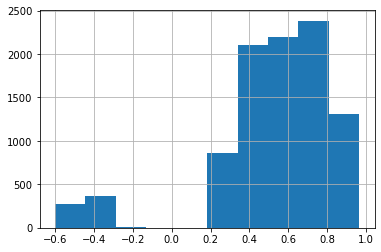

In [9]:
corr = corr.loc[corr.pval < 0.05]
corr.Correlation.hist()

## Merge RNAseq and histone


In [10]:
K562_histone_df = K562_histone_df.merge(corr, on=['TF','Gene']).drop_duplicates()
K562_histone_df

,TF,Gene,H3K4me3,bivalency,Correlation,pval
0,CEBPB,AC002467.7,599.0,inf,0.858114,1.284976e-14
5,CEBPB,AC092198.1,5006.0,inf,0.342047,1.860849e-02
15,CEBPB,AC093107.7,1754.5,inf,-0.348296,1.643303e-02
35,CEBPB,ACO1,130.0,425.0,0.626699,2.445052e-06
37,CEBPB,ALDH1B1,106.0,inf,0.602771,7.342628e-06
...,...,...,...,...,...,...
9492,SIN3A,ZC3HAV1,1121.0,inf,0.806824,7.514143e-12
9493,SIN3A,ZCCHC7,34.5,inf,0.708668,2.496119e-08
9500,SIN3A,ZCWPW1,5.5,inf,0.748481,1.460359e-09
9501,SIN3A,ZNF282,1.5,inf,0.754374,9.173114e-10


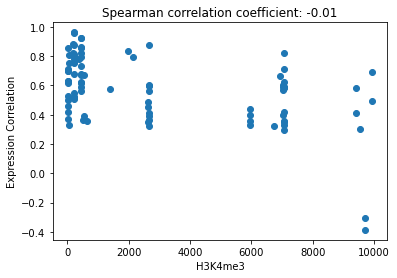

In [20]:
rho, p_value = spearmanr(K562_histone_df.H3K4me3, K562_histone_df.bivalency)
 
plt.scatter(K562_histone_df.bivalency, K562_histone_df.Correlation)
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.xlabel("H3K4me3")
plt.ylabel("Expression Correlation")
plt.show()